# Number of mergers a galaxy undergoes across a redshift range

In [1]:
%matplotlib inline

In [8]:
# Import everything we need for this calculation
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from scipy.integrate import quad
import astropy.units as u
import matplotlib.pyplot as plt

# Set the cosmology we are using
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

Define the function which provides the average time between mergers. In Ownsworth et al. (2014), this is given by $\Gamma$ and defined as $\tau_m / f_m(z)$. The merger fraction (careful to note this is the *merger* fraction and not the *pair* fraction) is usually given by the form $f_m = f_0(1+z)^m$.

In [9]:
def Gamma_fn(z, tau_m, f0, m, C=0.6):
    """
    Average time between merger events, Gamma(z).
    
    Args:
        z (float): redshift;
        tau_m (astropy quantity): timescale over which merging is visible;
        f0 (float): merger fraction at z = 0;
        m (float): slope of the merger fraction, of form f_m = f0(1+z)**m;
        C (float): fraction of pairs that actually merger;
    
    """
    # Average time between mergers = tau_m / f_m
    return tau_m / ((f0*(1+z)**m)*C)

The number of mergers a galaxy experiences, on average, is then the integral of this function over time. This is written as $N_\text{merg} = \int_{z_1}^{z_2} \frac{dt}{\Gamma(z)}$.

Ownsworth et al. (2014) put this in terms of redshift as $N_\text{merg} = \int_{z_1}^{z_2} \frac{1}{\Gamma(z)}\frac{t_H}{(1+z)}\frac{dz}{E(z)}$, where $E(z) = H(z)$.

**However**, I don't think this is right as $dt = \frac{- dz}{H_0 (1+z) E(z)} = \frac{- dz}{(1+z) H(z)}$ and many cosmology texts put $E(z) = H(z)/H_0$. This translates to an integrand of

$$ N_\text{merg} = -1 \times \int_{z_1}^{z_2} \frac{1}{\Gamma(z) (1+z) H(z)} dz$$

In [10]:
def int_fn(z, tau_m, f0, m, fn='mundy', C_merg=0.6):
    """
    The function to integrate wrt to redshift.
    
    Args:
        z (float): redshift;
        tau_m (astropy quantity): timescale over which merging is visible;
        f0 (float): merger fraction at z = 0;
        m (float): slope of the merger fraction, of form f_m = f0(1+z)**m;
        fn (str): either 'mundy' or 'ownsworth' to choose integral (see above text);
        C (float): fraction of pairs that actually merger;
    """
    if fn == 'mundy':
        # Mundy et al. (2016)
        return -1. * np.divide(1., Gamma_fn(z, tau_m, f0, m, C_merg) * cosmo.H(z) * (1+z))
    elif fn == 'ownsworth':
        # Ownsworth et al. (2014)
        return -1 * Gamma_fn(z, tau_m, f0, m, C_merg)**(-1) * cosmo.hubble_time * cosmo.H(z) / (1+z)
    else:
        return False

Work out the number of mergers a galaxy undergoes across a redshift range, and the associated error on this value.

To do this, we generate N samples of the parameters from a normal distribution using their average values and associated errors.

Using 999 / 1000 realizations...
N_merg = 0.34 (+0.22, -0.11)


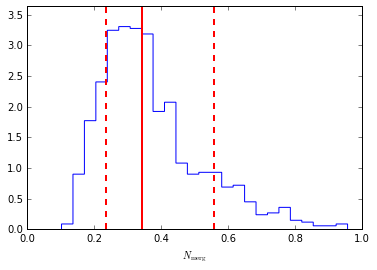

In [12]:
# =====================================
# Best-fit parameters and their errors
# =====================================
# # Ownsworth et al. (2014)
# tau_m, e_tau_m = 0.4, 0.2
# f0, e_f0 = 0.009, 0.002
# m, e_m = 2.9, 0.2
# C_merg = 1.0
# fn = 'ownsworth'

# Mundy et al. (2016)
tau_m, e_tau_m = 0.6*u.Gyr, 0.2*u.Gyr # Gyr
f0, e_f0 = 0.025, 0.004
m, e_m = 0.72, 0.20
C_merg = 0.6
fn = 'mundy'

# Number of realizations
N = 1000

# Redshift bounds
z_min = 0.3
z_max = 3.0

# =====================================

taus = (e_tau_m * np.random.randn(N)) + tau_m
f0s = (e_f0 * np.random.randn(N)) + f0
ms = (e_m * np.random.randn(N)) + m

# Ensure things are physical
mask = np.logical_and(f0s > 0., taus > 0.)
taus, f0s, ms = taus[mask], f0s[mask], ms[mask]

N_merg = []

print 'Using {0} / {1} realizations...'.format(mask.sum(), N)

for i in range(mask.sum()):
    N_merg_i = quad(int_fn, z_max, z_min, args=(taus[i], f0s[i], ms[i], fn, C_merg))[0]
    N_merg.append(N_merg_i)
    
N_av = np.nanpercentile(N_merg, 50.)
N_l = np.nanpercentile(N_merg, 15.6)
N_u = np.nanpercentile(N_merg, 84.4)

print 'N_merg = {0:1.2f} (+{1:1.2f}, -{2:1.2f})'.format(N_av, N_u-N_av, N_av-N_l)

# Plot the distribution
# =====================================
fig, ax = plt.subplots(1, 1)
n, bins, patches = ax.hist(N_merg, bins=np.arange(0, N_av + 3.*(N_u-N_av), N_av/10), 
                           normed=True, histtype='step')
ax.plot([N_av, N_av], [0, n.max()*1.1], '-r', lw=2)
ax.plot([N_l, N_l], [0, n.max()*1.1], '--r', lw=2)
ax.plot([N_u, N_u], [0, n.max()*1.1], '--r', lw=2)
ax.set_ylim(0, n.max()*1.1)
ax.set_xlabel('$N_\mathrm{merg}$')
# =====================================

Resulting distribution of $N_\text{merg}$ identifies the upper and lower $1\sigma$ uncertainties on the obtained value. If using the Ownsworth et al. (2014) parameters, it shows that the quoted error of $1.2 \pm 0.5$ was underestimated, seeing as we find $1.3^{+1.4}_{-0.5}$.